# 将神经形态Dynex芯片转化为Torch层

In [1]:
import math
import dynex
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch.optim import Adam

## 定义 dnx layer 类

In [2]:
from HybridQRBM.pytorchdnx import dnx
from HybridQRBM.optimizers import RBMOptimizer
from HybridQRBM.samplers import DynexSampler
print(dynex.__version__)

0.1.10


## 参数

In [3]:
# 定义训练的超参数
INIT_LR    = 1e-3
BATCH_SIZE = 12000 #64
EPOCHS     = 1
device = "cpu" # 仅使用Dynex，不使用GPU

## 定义模型

In [4]:
optimizer = RBMOptimizer(
                learning_rate=0.05,
                momentum=0.9,
                decay_factor=1.00005,
                regularizers=()
            );

sampler = DynexSampler(mainnet=True,

               num_reads=100, 
               annealing_time=1000, 
               debugging=False, 
               logging=False, 
               num_gibbs_updates=1, 
               minimum_stepsize=0.002);

In [5]:
class QModel(nn.Module):
    def __init__(self, n_hidden, sampler, optimizer, trainSteps):
        super().__init__();
        # Dynex 神经形态 layer
        self.dnxlayer = dnx(n_hidden, sampler=sampler, optimizer=optimizer, steps_per_epoch=trainSteps); 

    def forward(self, x):
        x = self.dnxlayer(x);
        return x;

## 加载数据

In [6]:
# 从灰度到黑白的转换函数
from torchvision import transforms
class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255 / 255.  # 输入的灰度级别的阈值范围为[0..255]，将其转换为[0..1]。

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  # 不改变数据类型。

data_transformer = transforms.Compose([
        #transforms.Grayscale(),
        transforms.ToTensor(),
        ThresholdTransform(thr_255=240)
    ])

In [7]:
# 加载MNIST数据集。
from torchvision.datasets import MNIST
trainData = MNIST(root="data", train=True, download=True,
	transform=data_transformer)
testData = MNIST(root="data", train=False, download=True,
	transform=data_transformer) 
print("[INFO] MNIST dataset loaded")

[INFO] MNIST dataset loaded


In [8]:
trainData

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [9]:
# 初始化训练、验证和测试数据加载器。
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

In [10]:
# 计算训练和验证集的每个周期的步骤数。
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
print(trainSteps,'train steps per epoch');

5 train steps per epoch


## 训练

In [11]:
#img_dim = len(trainData.data[0]);
n_hidden = 60;
model = QModel(n_hidden, sampler, optimizer, trainSteps);

In [12]:
for e in range(0, EPOCHS):
	print('EPOCH',e,'of',EPOCHS);
	# 将模型设置为训练模式。
	model.train()
	# 遍历训练集。
	for (x, y) in trainDataLoader:
		# 将输入发送到设备
		(x, y) = (x.to(device), y.to(device))
		# 执行前向传播并计算训练损失。
		pred = model(x);

EPOCH 0 of 1
DynexQRBM PyTorch Layer | batch data appended: 1
DynexQRBM PyTorch Layer | batch data appended: 2
DynexQRBM PyTorch Layer | batch data appended: 3
DynexQRBM PyTorch Layer | batch data appended: 4
DynexQRBM PyTorch Layer | batch data appended: 5
DynexQRBM PyTorch Layer | end of batch, sampling... 60000 x 784


file upload progress:   0%|          | 0.00/4.05M [00:00<?, ?B/s]

DynexQRBM PyTorch Layer | applying sampling result... 60000 x 784
DynexQRBM PyTorch Layer | SME: 0.009540 ACCURACY: 99.046021%


In [13]:
dnxModel = model.dnxlayer.errors

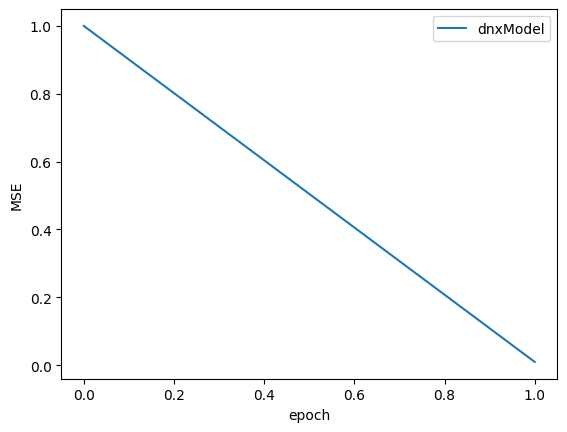

In [14]:
plt.figure()
plt.plot(dnxModel, label='dnxModel')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

## PyTorch CNN

In [15]:
# numChannels:
# 1 -> 灰度或二值图像
# 3 -> RGB彩色图像
# classes:
# 输出类别的数量




class BasicModel(nn.Module):
    def __init__(self, numChannels, classes):
         # 调用父类的构造函数：
        super().__init__()

        # 初始化第一组的CONV => RELU => POOL层。
        self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		
        # 初始化第二组的CONV => RELU => POOL层。
        self.conv2 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		
        # 初始化第一（也是唯一的）组FC => RELU层。
        self.fc1 = Linear(in_features=800, out_features=500)
        # self.fc1 = DynexLayer(in_features=800, out_features=500)
        self.relu3 = ReLU()
		
        # 初始化我们的softmax分类器。
        self.fc2 = Linear(in_features=500, out_features=classes)
        self.logSoftmax = LogSoftmax(dim=1)
        
        #self.conv = nn.Conv2d(1, 128, 3)
        #self.linear = DynexLayer(256, 2);
        

    def forward(self, x):
        # 通过我们的第一组CONV => RELU => 将输入传递
		# POOL layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
		# 将前一层的输出传递给第二层。
		# set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
		# 将前一层的输出展平并传递。
		# 通过我们唯一的FC => RELU层。
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
		# 将输出传递到我们的softmax分类器以获取输出。
		# 预测
        x = self.fc2(x)
        output = self.logSoftmax(x)
		# 返回输出预测
        return output
        
        #x = self. conv(x)
        #x = x.view(-1, 256)
        #return self.linear(x)

In [16]:
# 定义训练超参数
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# 定义训练和验证集的拆分
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
# 设置用于训练模型的设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# 加载MNIST数据集
#from torchvision.datasets import MNIST
#print("[INFO] loading the MNIST dataset...")
#trainData = MNIST(root="data", train=True, download=True,
#	transform=ToTensor())
#testData = MNIST(root="data", train=False, download=True,
#	transform=ToTensor())

In [18]:
# 加载CIFAR10数据集。
from torchvision.datasets import CIFAR10
print("[INFO] loading the CIFAR10 dataset...")
trainData = CIFAR10(root="data", train=True, download=True,
	transform=ToTensor())
testData = CIFAR10(root="data", train=False, download=True,
	transform=ToTensor())

[INFO] loading the CIFAR10 dataset...


100%|██████████| 170498071/170498071 [00:46<00:00, 3647668.75it/s]


Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


In [19]:
# 计算训练/验证集的拆分。
print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))
print(numTrainSamples,'train samples and',numValSamples,'validation samples');

[INFO] generating the train/validation split...
37500 train samples and 12500 validation samples


In [20]:
# 初始化训练、验证和测试数据加载器。
trainDataLoader = DataLoader(trainData, shuffle=True,
	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

In [21]:
# 计算训练集和验证集的每个周期的步骤数。
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE
print(trainSteps,'train steps and',valSteps,'validation steps');

585 train steps and 195 validation steps


In [22]:
# 初始化模型。
print("[INFO] initializing the model...")
model = BasicModel(numChannels=1, classes=len(trainData.dataset.classes)).to(device)

[INFO] initializing the model...


In [23]:
# 初始化我们的优化器和损失函数。
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()

In [24]:
# 初始化一个字典来存储训练历史。

H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

## 训练模型

In [25]:
# 训练：遍历周期。

for e in range(0, EPOCHS):
	# 将模型设置为训练模式
	model.train()
	# 初始化总的训练和验证损失
	totalTrainLoss = 0
	totalValLoss = 0
	# 初始化训练中正确预测的数量。
	# and 验证步骤
	trainCorrect = 0
	valCorrect = 0
	# 遍历训练集
	for (x, y) in trainDataLoader:
		# 将输入发送到设备。
		(x, y) = (x.to(device), y.to(device))
		# 执行前向传播并计算训练损失。
		pred = model(x)
		loss = lossFn(pred, y)
		# 清零梯度，执行反向传播步骤
		# 并更新权重。
		opt.zero_grad()
		loss.backward()
		opt.step()
		# 将损失添加到到目前为止的总训练损失中，
		# 计算正确预测的数量。
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()
	
    # 评估：在评估时关闭自动微分。
	with torch.no_grad():
    	# 将模型设置为评估模式。
		model.eval()
    	# 遍历验证集。
		for (x, y) in valDataLoader:
        	# 将输入发送到设备。
		    (x, y) = (x.to(device), y.to(device))
        	# 进行预测并计算验证损失。
		    pred = model(x)
		    totalValLoss += lossFn(pred, y)
        	# 计算正确预测的数量
		    valCorrect += (pred.argmax(1) == y).type(
                torch.float).sum().item()

	# 计算平均训练和验证损失。
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# 计算训练和验证的准确率
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	valCorrect = valCorrect / len(valDataLoader.dataset)
	# 更新我们的训练历史。
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)
	# 打印模型的训练和验证信息。
	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
        avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
        avgValLoss, valCorrect))

RuntimeError: Given groups=1, weight of size [20, 1, 5, 5], expected input[64, 3, 32, 32] to have 1 channels, but got 3 channels instead

## 统计数据

In [ ]:
# 在测试评估中关闭自动微分。
with torch.no_grad():
	# 将模型设置为评估模式。
	model.eval()
	
	# 初始化一个列表以存储我们的预测。
	preds = []
	# 遍历测试集。
	for (x, y) in testDataLoader:
		# 将输入发送到设备。
		x = x.to(device)
		# 进行预测并将它们添加到列表中。
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
# 生成一个分类报告。
print(classification_report(testData.targets.cpu().numpy(),
	np.array(preds), target_names=testData.classes))

## 画出结果

In [ ]:
# 绘制训练损失和准确率。
# 使用"ggplot"样式
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
#plt.savefig(args["plot"])
# 保存到硬盘
#torch.save(model, args["model"])